### Optimal control of deterministic Wilson-Cowan network models with delays
This notebook shows how to compute the optimal control (OC) signal for the WC model for a simple example task in networks with delays.

In [373]:
import matplotlib.pyplot as plt
import numpy as np
import os

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_wc
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We stimulate the system with a known control signal, define the resulting activity as target, and compute the optimal control for this target. We define weights such that precision is penalized only (w_p=1, w_2=0). Hence, the optimal control signal should converge to the input signal.

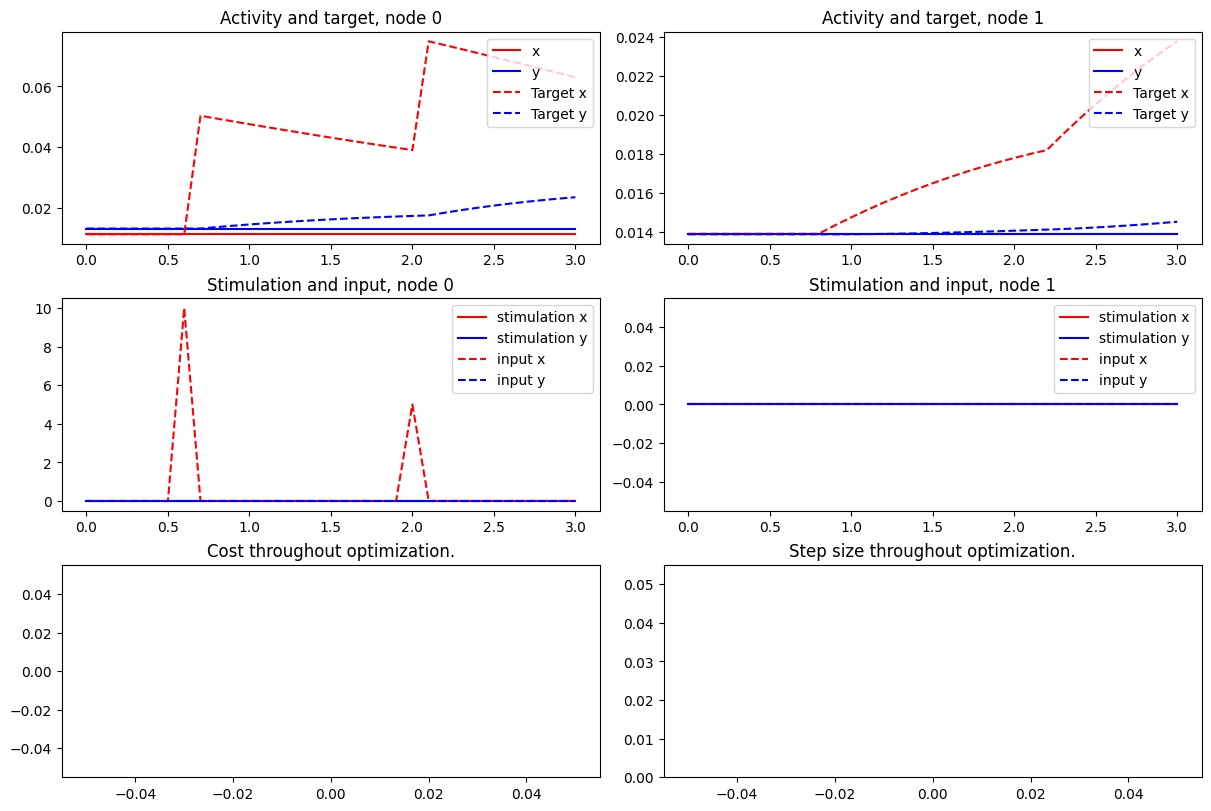

In [374]:
cmat = np.array( [[0., 0.], [1., 0.]] ) # diagonal elements are zero, connection strength is 1 (0.5) from node 0 to node 1 (from node 1 to node 0)
dmat = np.array( [[0., 0.], [0.1, 0.]] ) # delay from 0 to 1, no delay from 1 to 0

model = WCModel(Cmat=cmat, Dmat=dmat)
duration, dt = 1000., 0.1
model.params.duration = duration
model.params.dt = dt
model.params.K_gl = 10.
model.params.signalV = 1.

model.run()

e0 = model.exc[0,-1]
e1 = model.exc[1,-1]
i0 = model.inh[0,-1]
i1 = model.inh[1,-1]

model.params["exc_init"] = np.array([[e0, e0, e0], [e1, e1, e1]])
model.params["inh_init"] = np.array([[i0, i0, i0], [i1, i1, i1]])

duration = 3.
model.params.duration = duration
model.run()

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in E-channel in node 0

zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = zero_input.copy()
input[0,6] = 10. # other functions or random values can be used as well
input[0,20] = 5.
#input[0,26] = 1.

input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["exc_ext"] = input_nw[:,0,:]
model.params["inh_ext"] = input_nw[:,1,:]
model.run()
# Define the result of the stimulation as target
target = np.concatenate( (np.stack( (model.params["exc_init"][:,-1], model.params["inh_init"][:,-1]), axis=1)[:,:, np.newaxis], np.stack( (model.exc, model.inh), axis=1)), axis=2)

# Remove stimuli and re-run the simulation
model.params["exc_ext"] = zero_input_nw[:,0,:]
model.params["inh_ext"] = zero_input_nw[:,0,:]
model.run()

# combine initial value and simulation result to one array
state = np.concatenate( (np.stack( (model.params["exc_init"][:,-1], model.params["inh_init"][:,-1]), axis=1)[:,:, np.newaxis], np.stack( (model.exc, model.inh), axis=1)), axis=2)
plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

In [ ]:
We now compute the optimal control. Compute 100 iterations first, then perform more iterations until convergence.

Compute control for a deterministic system
Cost in iteration 0: 2.9962651217870792e-05
Cost in iteration 1: 2.9961865638658495e-05
Cost in iteration 2: 2.996029384488882e-05
Cost in iteration 10: 2.9031819984049618e-05
Cost in iteration 50: 5.513409497606013e-07
Cost in iteration 100: 2.760678568243837e-07
Final cost : 2.760678568243837e-07


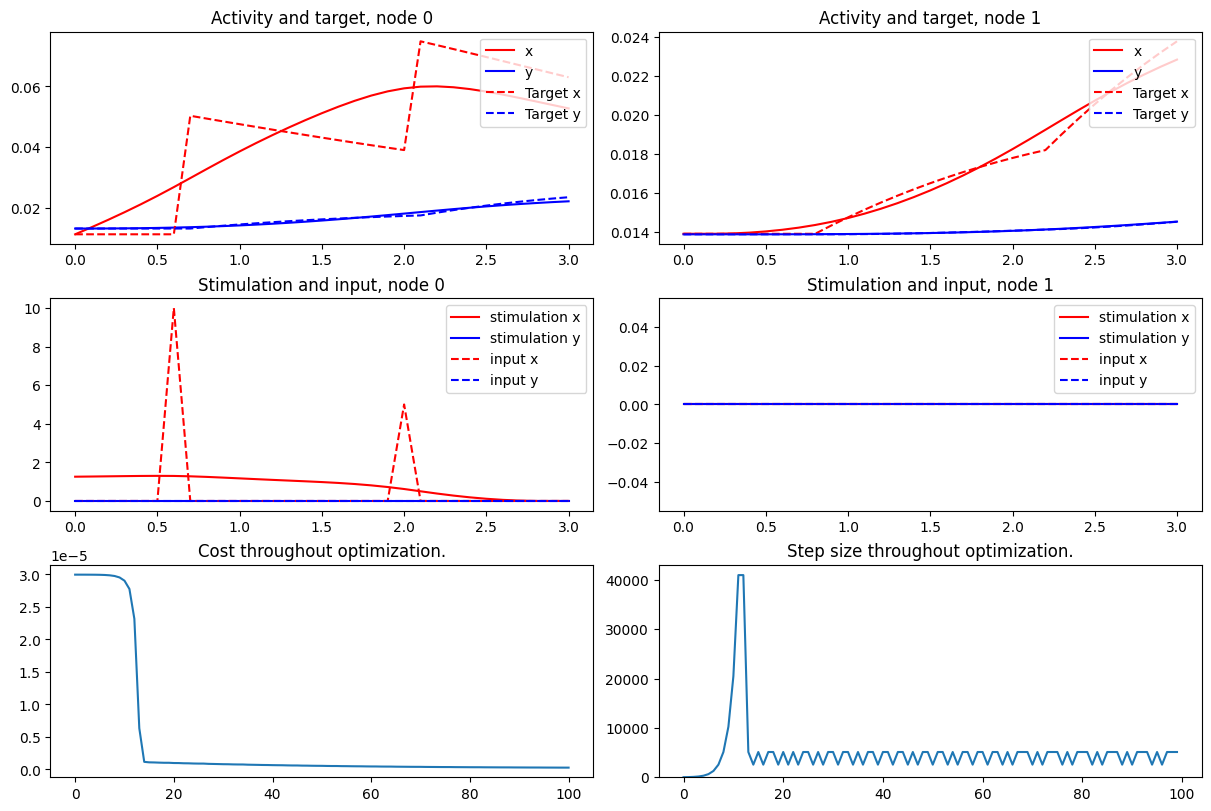

In [375]:
prec_mat = np.zeros( (model.params.N, len(model.output_vars)) )
prec_mat[1,0] = 1. # only measure in y-channel in node 1

model_controlled = oc_wc.OcWc(model, target, w_p=1, w_2=0, print_array=[1,2,10,50,100,200,300,400,500], control_matrix=control_mat, precision_matrix=prec_mat)
model_controlled.optimize(100)

state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

Compute control for a deterministic system
Cost in iteration 0: 8.474150326512747e-09
Cost in iteration 1: 8.471406474476676e-09
Cost in iteration 2: 8.469993405321463e-09
Cost in iteration 10: 8.454236780063219e-09
Cost in iteration 50: 8.37620499847183e-09
Cost in iteration 100: 8.280551693373806e-09
Cost in iteration 200: 8.093782670102256e-09
Cost in iteration 300: 7.913930344060703e-09
Cost in iteration 400: 7.740578171015862e-09
Cost in iteration 500: 7.57347335402281e-09
Final cost : 7.57347335402281e-09


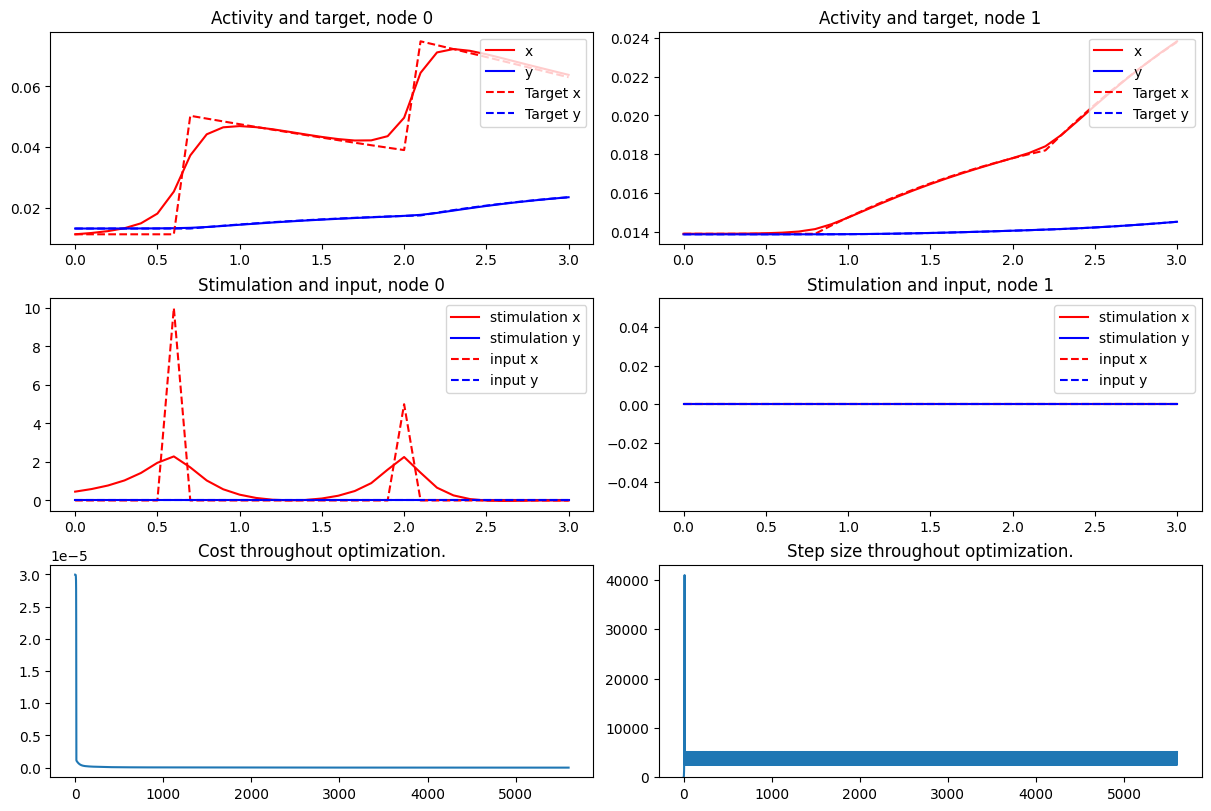

In [386]:
# perofrm another 500 iterations to improve result
# repeat execution to add another 500 iterations
# converence to the input stimulus is relatively slow for the WC nodel
model_controlled.optimize(500)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)